In [1]:
!pip install pytorch=1.1.0 torchvision -c pytorch -y


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [27]:
import os
import torch
import torchvision
from torchvision import transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist
from collections import defaultdict

In [28]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Specific classes of interest (utensils)
UTENSILS_CLASSES = ['fork', 'knife', 'spoon']

In [29]:
# Load pre-trained Faster R-CNN model
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
# Load pre-trained Mask R-CNN model
mask_rcnn_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [31]:
# Define the transformation: convert images to tensor
transform = T.Compose([T.ToTensor()])



In [32]:
#function to get predictions

def get_predictions(pred, threshold=0.8, objects=None):
    """Get filtered predictions based on threshold and object classes."""
    predicted_classes = [
        (COCO_INSTANCE_CATEGORY_NAMES[i], p, [(box[0], box[1]), (box[2], box[3])])
        for i, p, box in zip(
            list(pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy())
        )
    ]
    # Filter predictions based on threshold
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    # Further filter predictions based on object classes if provided
    if objects:
        predicted_classes = [(name, p, box) for name, p, box in predicted_classes if name in objects]
    return predicted_classes

In [33]:
#to detect bundles in an image
def identify_bundles(boxes, proximity_threshold=50):
    """Identify bundles of objects based on proximity."""
    if len(boxes) < 2:
        return []

    # Calculate centers of the bounding boxes
    centers = [(int((box[0][0] + box[1][0]) / 2), int((box[0][1] + box[1][1]) / 2)) for box in boxes]
    dist_matrix = cdist(centers, centers)
    np.fill_diagonal(dist_matrix, np.inf)  # Avoid self-comparison

    bundles = []
    used_indices = set()

    for i in range(len(boxes)):
        if i in used_indices:
            continue

        # Find items close to the current item based on proximity threshold
        close_items = np.where(dist_matrix[i] <= proximity_threshold)[0]
        if len(close_items) > 0:
            bundle = [i] + list(close_items)
            bundle = [idx for idx in bundle if idx not in used_indices]
            if len(bundle) > 1:
                bundles.append([boxes[idx] for idx in bundle])
                used_indices.update(bundle)

    return bundles


In [34]:
def draw_bundles(img, bundles, rect_th=2, text_size=0.5, text_th=2, download_image=False, img_name="img"):
    """Draw bounding boxes around bundles and label them."""
    image = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for i, bundle in enumerate(bundles, 1):
        min_x = min([box[0][0] for box in bundle])
        min_y = min([box[0][1] for box in bundle])
        max_x = max([box[1][0] for box in bundle])
        max_y = max([box[1][1] for box in bundle])

        # Draw rectangle and label for each bundle
        cv2.rectangle(image, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (0, 0, 255), rect_th)
        cv2.putText(image, f"Bundle {i}", (int(min_x), int(min_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 0, 255), text_th)

    # Add total bundle count to image
    cv2.putText(image, f"Total Bundles: {len(bundles)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the image with drawn bundles
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if download_image:
        plt.savefig(f'{img_name}.png')
    plt.show()


In [35]:
def evaluate_folder(folder_path, model, threshold=0.5, objects=None, save_visualizations=False, output_folder="output"):
    """Evaluate images in a folder for bundles of utensils."""
    if save_visualizations and not os.path.exists(output_folder):
        os.makedirs(output_folder)

    bundle_map = {}

    for img_filename in os.listdir(folder_path):
        if not img_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(folder_path, img_filename)
        try:
            img = Image.open(img_path).convert("RGB")
        except IOError:
            print(f"Error opening image file: {img_filename}")
            continue

        img_tensor = transform(img)

        # Model inference
        with torch.no_grad():
            pred = model([img_tensor])

        # Get predictions and identify bundles
        pred_thresh = get_predictions(pred, threshold, objects)
        boxes = [pred[2] for pred in pred_thresh]
        bundles = identify_bundles(boxes, proximity_threshold=50)

        # Update bundle map
        bundle_map[img_filename] = len(bundles)

        # Visualization
        if save_visualizations:
            draw_bundles(img_tensor, bundles, rect_th=2, text_size=0.5, text_th=2, download_image=True, img_name=os.path.join(output_folder, img_filename))

    # Create and display results in a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(bundle_map.keys(), bundle_map.values())
    plt.title("Number of Bundles per Image")
    plt.xlabel("Image Filename")
    plt.ylabel("Number of Bundles")
    plt.xticks(rotation=90)
    plt.show()

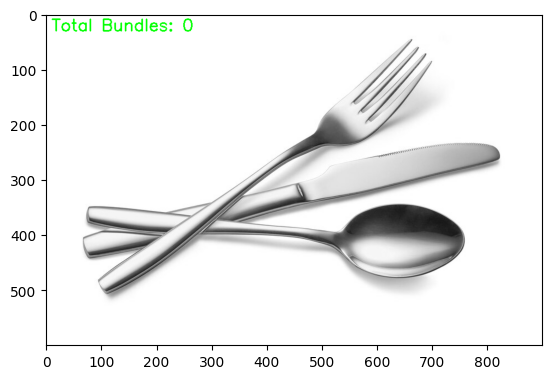

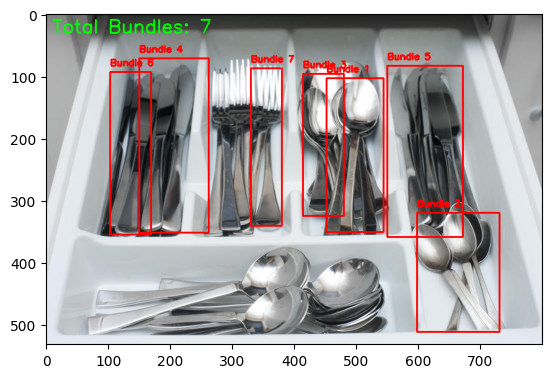

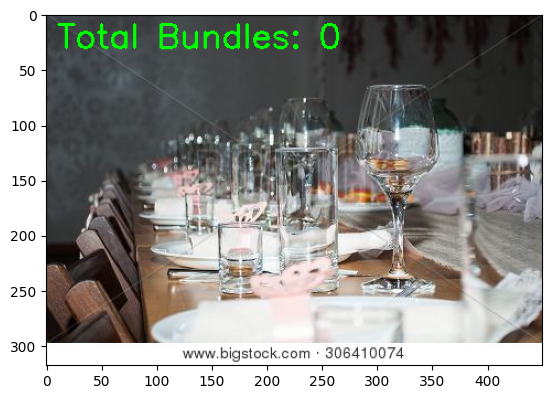

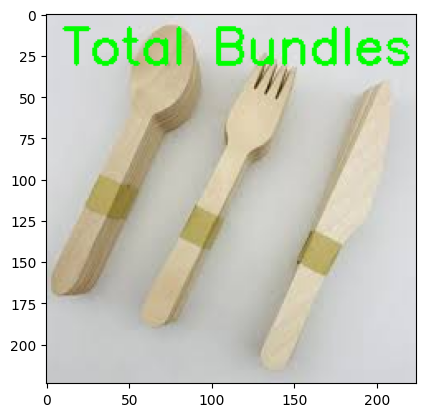

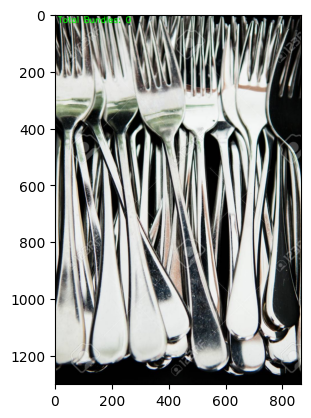

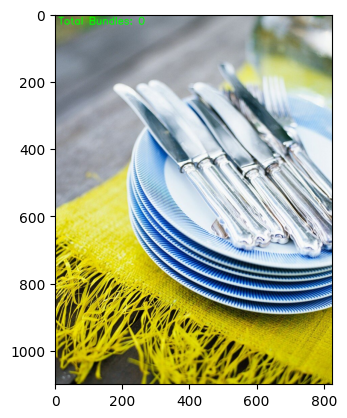

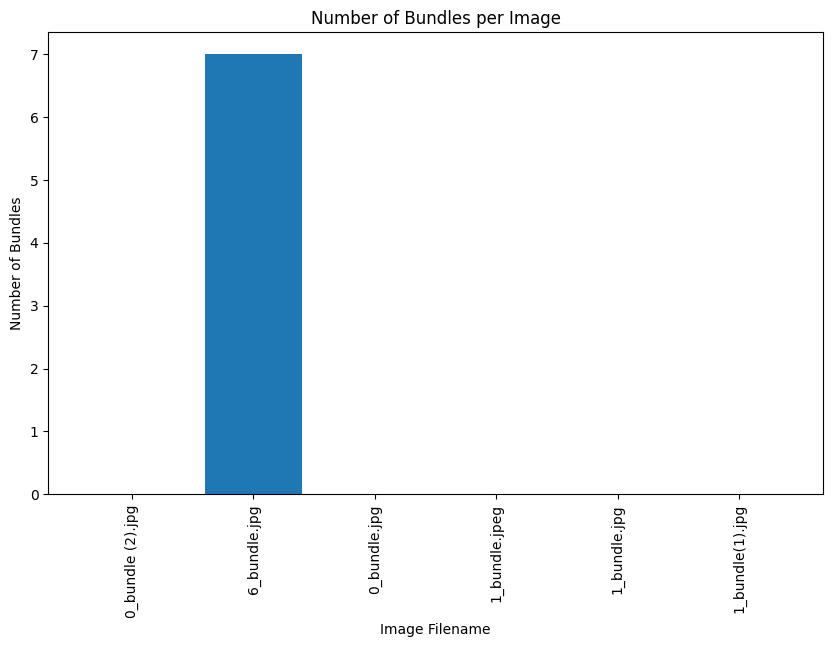

In [36]:
folder_path = "/content/drive/MyDrive/bundles"

# Evaluate folder with Faster R-CNN model
evaluate_folder(folder_path, faster_rcnn_model, threshold=0.5, objects=UTENSILS_CLASSES, save_visualizations=True, output_folder="output")

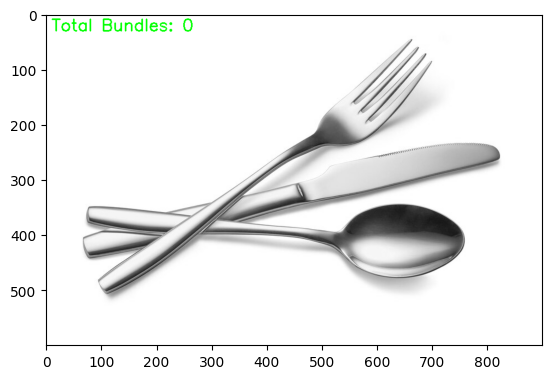

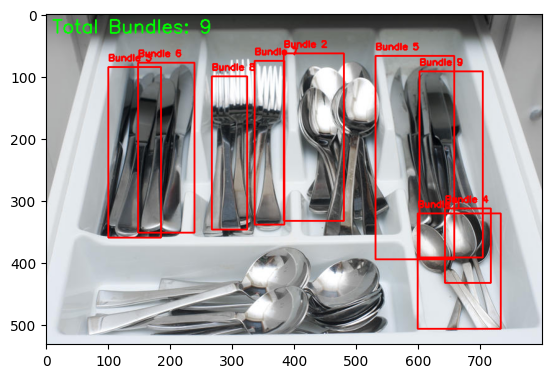

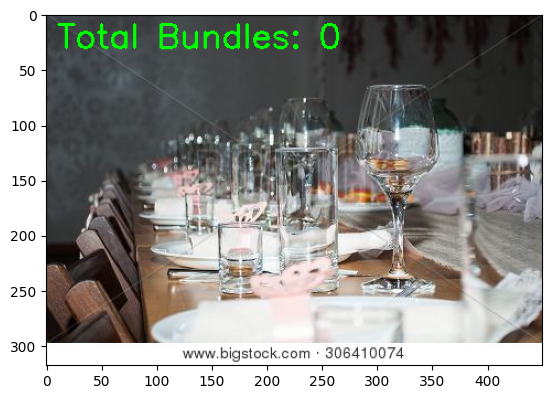

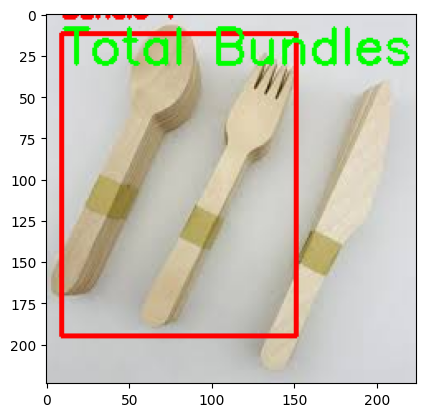

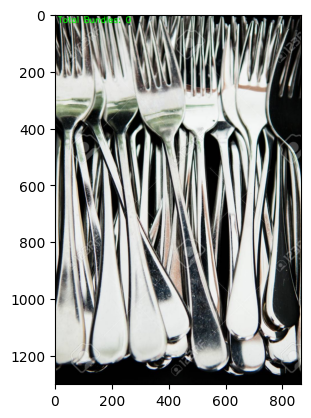

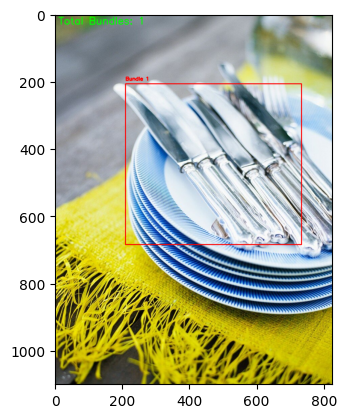

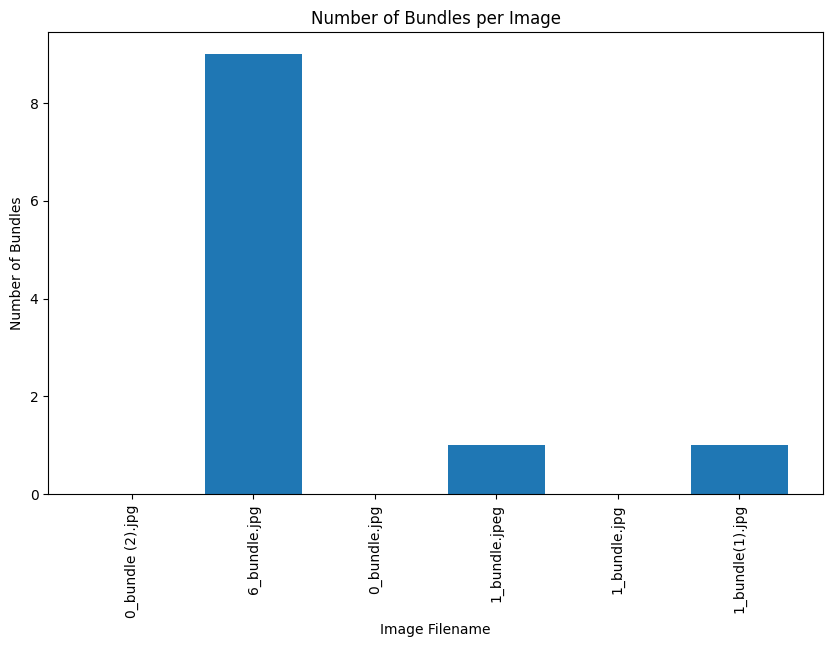

In [37]:
evaluate_folder(folder_path, mask_rcnn_model, threshold=0.5, objects=UTENSILS_CLASSES, save_visualizations=True, output_folder="output")